In [2]:
%%javascript
IPython.notebook.events.off('checkpoint_created.Notebook');
IPython.notebook.events.off('notebook_saved.Notebook');

<IPython.core.display.Javascript object>

###  Дмитрий МАРЬИН - группа dspr-58 - Car Price prediction   

#### <span style="color: LightSeaGreen;"> Юнит 7. Часть II - Проект 6. ВЫБИРАЕМ АВТО ВЫГОДНО</span>

моя страничка на GIT: https://github.com/valkoder

это **вторая часть машинное обучение** - dmar_car_part_2.ipynb,  
первая часть подготовка данных - в ноутбуке dmar_car_part_1.ipinb

<a name="top"></a>  
**Навигация:**
- #### [setup](#import)
- #### [исходные датасеты](#df)
- #### [про метрику MAPE](#mape)
- #### [baseline model - CatBoost regressor](#naive)
- #### [особенности CatBoost](#cb)
- #### [попытки улучшить рузультаты с CatBoost](#att1)
- #### [другие модели](#models)  
- #### [DecisionTreeRegressor](#dec_tree) - 20.50%, Kagle 17.04% my position 164
- #### [ExtraTreesRegressor](#et) - **14.58%**, Kagle **12.55%** my posision 49
- #### [RandomForestRegressor](#rf) - **12.71%** Kagle **13.56%**
- #### [XGBoost](#xgb) - **13.32**, Kaggle **12.50%** my position 48
- #### [GradientBoosting](#grad) - **12.50**, Kaggle **12.48%** my position 48  
- #### [Stacking](#stack) - **12.97**, Kaggle **12.21%** my position **44**
- #### [LINKS](#links)
- #### [список литературы](#lit)
- #### [to END](#end)

 <a name="import"></a> 
#### setup и загрузка файлов

In [2]:
# VERSION = XX
R_S = 42 # random seed
VAL_SIZE = 0.20 # validation part (X_test) in %
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import VotingRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from datetime import timedelta, datetime, date

def display_all(df):     # display many columns / raws
   with pd.option_context('display.max_rows', 6): # number of rows
      with pd.option_context('display.max_columns', 35): # columns
          display(df)

def col_info(df, col):  # records, NaN, unique, duplicates
    print("всего записей в столбце ", col, " = ", 
          df[col].count())
    print("NaN в столбце ",  col, " = ", df[col].isna().sum(), 
          ",  в процентах = ", 
          "{0:.0%}".format(df[col].isna().sum() / len(df)))
    print("уникальных в столбце ", col, " = ", 
          df[col].nunique(dropna=False))
    
    a = df[df[col].duplicated(keep=False)].count()[1]    
    print("всего записей-дубликатов в столбце ", col, " = ", a)
    
    display_all(pd.DataFrame(df[col].value_counts(sort=True, dropna=False)))

def info_table(df): # таблица NaN и unique по столбцам
    mv = df.isnull().sum()
    mvp = 100 * df.isnull().sum() / len(df)
    mv2 = df.nunique(dropna=False)
    mv_table = pd.concat([mv, mvp, mv2], axis=1)
    mv_table2 = mv_table.rename(columns = {0: 'NaN', 1: '% NaN', 2: 'uniq'})
    mv_table2 = mv_table2[mv_table2.iloc[:,1] >= 0].round(1)
    return mv_table2
def my_mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
# грузим файлы
df_sub = pd.read_csv('empty_submission.csv')
df = pd.read_csv('beta_200.csv') #see dmar_car_part_1.ipinb
df_a = pd.read_csv('alpha_200.csv') #see dmar_car_part_1.ipinb

In [3]:
# разметим категориальные столбцы - для CatBoost, для XGB - убрать
cat_list = ['S01', 'S02', 'S03', 'S06', 'S10', 
           'S13', 'S14', 'S15', 'S16', 'S17', 'S21', 'S22']
for col in cat_list:
    df_a[col] = df_a[col].astype('category', errors='raise')
    df[col] = df[col].astype('category', errors='raise')

In [ ]:
df['price'] = df['price'].astype('int64', errors='raise')
df['S05'] = df['S05'].astype('int64', errors='raise')
df['S08'] = df['S08'].astype('int64', errors='raise')
df['S16'] = df['S16'].astype('bool', errors='raise')
df_a['S16'] = df_a['S16'].astype('bool', errors='raise')
df['S17'] = df['S17'].astype('bool', errors='raise')
df_a['S17'] = df_a['S17'].astype('bool', errors='raise')
df['S21'] = df['S21'].astype('bool', errors='raise')
df_a['S21'] = df_a['S21'].astype('bool', errors='raise')
df['S22'] = df['S22'].astype('bool', errors='raise')
df_a['S22'] = df_a['S22'].astype('bool', errors='raise')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45112 entries, 0 to 45111
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   S01     45112 non-null  category
 1   S02     45112 non-null  category
 2   S03     45112 non-null  category
 3   S05     45112 non-null  int64   
 4   S06     45112 non-null  category
 5   S07     45112 non-null  int64   
 6   S08     45112 non-null  int64   
 7   S10     45112 non-null  category
 8   S11     45112 non-null  int64   
 9   S13     45112 non-null  category
 10  S14     45112 non-null  category
 11  S15     45112 non-null  category
 12  S16     45112 non-null  bool    
 13  S17     45112 non-null  bool    
 14  S21     45112 non-null  bool    
 15  S22     45112 non-null  bool    
 16  S23     45112 non-null  int64   
 17  S24     45112 non-null  float64 
 18  S25     45112 non-null  float64 
 19  price   45112 non-null  float64 
dtypes: bool(4), category(8), float64(3), int64(5)
memo

#### исходные датасеты <a name="df"></a> 
(названия колонок в них одинаковые, кроме последних - 'sell_id' и 'price')

|поле |значение        |количество уникальных|
|-----|----------------|---------------------|
|S01	|тип авто	|24|
|S02	|производитель	|12|
|S03	|цвет	|16|
|S05	|мощность	|314|
|S06	|топливо	|5|
|S07	|пробег	|> 10тыс|
|S08	|модельный возраст	|69|
|S10	|двери	|5|
|S11	|возраст авто	|72|
|S13	|КПП	|4|
|S14	|владельцы|	3|
|S15	|привод	|3|
|S16	|ПТС	|2|
|S17	|руль	|2|
|S21	|"оптовик"	|2|
|S22	|"торг"	|2|
|S23	|годовой пробег| |	
|S24	|лог годового пробега	| |
|S25	|лог мощности	| |
|S30	|число слов| 1179|	
|S31	|лог числа слов	| |
|price	|price	| |

<a name="naive"></a> 
#### модель из baseline - CatBoost regressor
все ссылки лежат в разделе **[ссылки](#links)**   

**Начальные результаты: MAPE: 13.04%, Kaggle 29%, my position 260**  
без логарифмирования - 15.46%

In [7]:
X = df.drop(['price'], axis=1) # полный обучающий набор    
y = df.price.values # значения для проверки обучающего
Z = df_a.drop(['sell_id'], axis=1) # набор для submission
# TRAIN TEST split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = VAL_SIZE, random_state = R_S)

In [8]:
# Точность по метрике MAPE: 13.04%
model = CatBoostRegressor(iterations = 5000,
                          random_seed = R_S,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)
model.fit(X_train, 
          y = np.log(y_train),     # тут логарифм
          cat_features=cat_list,
          eval_set=(X_test, np.log(y_test) ),  # и тут логарифм
          verbose_eval=0,
          use_best_model = True,
          plot=False)
predict_new = np.exp(model.predict(X_test)) # тут возводим в СТЕПЕНЬ
print(f"Точность по метрике MAPE: {(my_mape(y_test, predict_new))*100:0.2f}%")

Точность по метрике MAPE: 13.02%


Результаты 13% и 29% на Каггле примерно такие-же как и в baselaine. Попробуем их улучшить.

<a name="mape"></a>  
#### про метрику MAPE

MAPE (or MAPD mean absolute percentage deviation) 
- несимметрично реагирует на ошибку предсказания - по-разному в разные стороны  если модель ошибается в сторону занижения таргета, то mape не может превысить 100%, но если модель выдает завышенные предсказания, то у mape нет верхнего предела 

#### негативные результаты экспериментов с данными

+ попытка использовать специальный тип данных pandas **ordered Categorical** dtype (from `pandas.api.types`) не удалась. 
CatBoostError: Invalid type for cat_feature ....  =NaN. Да и сама pandas похоже толком этот `CategoricalDtype` не поддердживает - тоже воспринимает его как NaN  
+ созданные новые бинарные признаки 'оптовик' S21 и 'торг 'S22 на метрику не влияют  
+ удаление из датасета второстепеных полей ('возраст модельного года' S08, 'топливо' S06, 'тип трансмиссии' S13, 'двери' S10' и т.п - на метрику не влияют
+ сортировки данных в ключевых полях - на метрику не влияют
+ создание выделение "привлекательных" категорий (групировка возраста авто на меньшее количество классов, выделение их по типу one-hot) - на метрику не влияют
+ новые признаки полученные из колонки 'описание' - наличие в ней слов - 'ТО', 'гарантия', 'сервисная книжка', 'мимо'  - на метрику не влияют

<a name="cb"></a>  
#### особенности CatBoost  
то немногое, что удалось найти
+ Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
+ CatBoost всеьма продвинутый пакет, у него свой "интеллектуальный" encoding сырых данных включая анализ данных и разные подходы к числовым, категориальным и текстовым, свой one-hot encoding, он сам создает новые фичи и их комбинации

Получается, что предобработка и изощренный Feature Engineering ему вроде как не нужны

<a name="att1"></a>  
#### попытки улучшить результаты с CatBoost

**добавление поля S30 'счетчик слов' в 'description' и S31 его логарифма**):
+  улучшило MAPE до **12.78%, на Kaggle 21.75%, my position 217** в leaderboard 

не реализовано:
- общий пробег разделить на количество слов
- продолжить работу с количеством слов - найти количество "!" (эмоции), кавычки (признак дилера), тире (манера письма)

#### CatBoost parameters to tune:
|argument	|description|
|-----------|-----------|
|iterations=500	|max number of trees|
|learning_rate=0.03	|reduce gradient step, small -> more time|
|depth=6	|of the tree. can be 1-32. good 4 - 10|
|l2_leaf_reg=3	|values for the regularizer. any pos values|
|border_count=32	|# splits for num features. from 1 to 255|
|ctr_border_count=50	|# splits for cat. from 1 to 255 inclusively|

Ручной подбор параметро существенно картину не меняет.  
Grid Search - для CatBoost долго, поэтому не использовался

#### библиотеки ML для задач регрессии  - выбор моделей
+ линейные методы - Linear Regression, Ridge Regression, Lasso Regression, Gausian Regression, Polynomial Regression - не подходят к нашей задаче (сложные данные с не линейными отношениями (связями) между признаками
+ Neural Network Regression, Deep Learning using Keras library в этом задании не используем
+ KNN Model - хороший метод классификации, но не для нашей задачи
+ Логистическая Регрессия - Logistic Regression  (S-curve based) врядли (будет огромное число классов), попробуем
+ Decision Tree Regression, Random Forest, ансамблевые методы - будем применять далее
+ Машины Опорных Векторов - Support Vector Machine не для нашей задачи

<a name="models"></a>  
+ на бейслайне после обработки данных 13.04%, но на Кагле 29% и позиция 260
#### проверяем модели  
+ [DecisionTreeRegressor](#dec_tree) - 20.50%, Kagle 17.04% my position 164
+ [ExtraTreesRegressor](#et) - **14.58%**, Kagle **12.55%** my posision **49**
+ [RandomForestRegressor](#rf) - **12.71%** Kagle **13.56%**
+ [XGBoost](#xgb) - **13.32**, Kaggle **12.50%** my position **48**
+ [GradientBoosting](#grad) - **12.50**, Kaggle **12.48%** my position **48**

<a name="dec_tree"></a>  
#### DecisionTreeRegressor -  20.50%, Kagle 17.04% my pos 164

**BaggingRegressor**  
Код ниже обучает ансамбль из **500 деревьев** принятия решений, каждый из которых **обучается на 100 экземплярах**, случайно выбранных из обучающего набора **с заменой** (пример **бэггинга**,  
но если вы хотите взамен применять **вставку**,  
тогда просто установите `bootstrap=False`).  

Вместо построения экземпляра `BaggingRegressor` и его передачи экземпляру `DecisionTreeRegressor` можно применить специально созданный для этого класс  
`RandomForestRegressor`, который является более удобным и оптимизированным
для деревьев принятия решений   
`BaggingREgressor` - использует  `DecisionTreeRegressor`!

`BaggingClassifier`остается полезным, если нужен пакет чего-то, отличающегося от деревьев принятия решений.

Трудно сказать заранее, будет ли `RandomForestClassifier`
выполняться лучше или хуже `ExtraTreesClassifier`.  

Как правило, единственный способ узнать - попробовать оба и сравнить их с применением перекрестной проверки (подстраивая гиперпараметры с использованием решетчатого поиска).

Начнем с `ExtraTreesRegressor `

<a name="et"></a>  
#### ExtraTreesRegressor - **14.58%**, Kagle **12.55%** my posision **49**

In [ ]:
# no log  - at home = MAPE: 14.58%  Kag = Score: 12.54712  now pos 49  
model = ExtraTreesRegressor(random_state=R_S,
                            n_estimators=100, # default 100
                            # criterion='squared_error', # give error!
                            max_depth=None,
                            max_features='auto',
                            bootstrap=False,
                            oob_score=False,
                            # n_jobs=None, # -1 error 
                            verbose=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"по метрике MAPE: {(my_mape(y_test, y_pred))*100:0.2f}%")

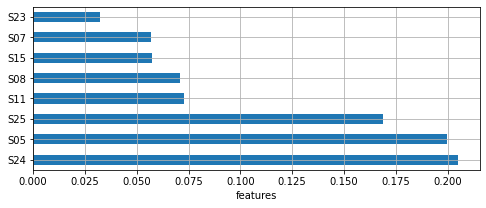

In [28]:
# most important features
features = pd.Series(model.feature_importances_, index=X.columns)
plt.subplots(figsize=(8, 3))
features.nlargest(8).plot(kind='barh',grid=True)
plt.xlabel('features')
plt.show()

<a name="rf"></a>  
#### RandomForestRegressor  -  **12.71%** Kagle **13.56%** 

#### Voting Regressor 

на базе RandomForest, ExtraTrees и SVM не дает улучшения - 43%,  
если выкинуть SVR получается лишь 14.52% и на Кагле - 13% (хуже чем просто ExtraTrees)

<a name="xgb"></a>  
#### XGBoost - **13.32**, Kaggle **12.50%** my position **48**

<a name="grad"></a>  
#### GradientBoosting - **12.48**, Kaggle **12.48%** my position **48**

Хороший результат после ручной настройки параметров. 
Поразительное совпадение метрик на обучающем наборе и на Кагде 12.50% vs 12.48%. 

<a name="stack"></a>  
#### Stacking - **12.97**, Kaggle **12.21%** my position **44**

#### Итоги  
Материалы модуля отработаны за исключением парсинга. К сожалению не хватило времени освоить NLP.
Задача отработана на обучающем датасете с ценой `all_auto_ru_09_09_2020.csv`.  

Удалось минимизировать заданную метрику (MAPE) - 12.48% на датасете из бейслайна и 12.21% на Кагле. Доволен полученным 44 местом в лидерборде. В прошлых проектах мне это не удавалось.

<a name="links"></a>  
### [LINKS](#coders)   
+ #### [метрика MAPE](#mape)
+ #### [CatBoost](#catb)
+ #### [XGBoost](#x)
+ #### [encoding](#enc)





<a name="mape"></a>  
[Wiki article about MAPE](http://en.wikipedia.org/wiki/Mean_absolute_percentage_error) 
[sklearn.metrics.mean_absolute_percentage_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html?highlight=mape)   
Note here that **the output is not a percentage in the range `[0, 100]`** and a value of 100 does not mean 100% but 1e2.  
[scikit-learn user guide - Mean absolute percentage error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error)  

<a name="catb"></a>  
#### [Using Grid Search to Optimise CatBoost Parameters](https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html)
#### [Hyperparameter Tuning and Optimization(CatBoost)](https://medium.com/aiplusoau/hyperparameter-tuning-a5fe69d2a6c7)
[CatBoost от Яндекса. Разбираемся](https://xn--80ajickj6abfedo.xn--p1ai/2019/04/29/catboost-%D0%BE%D1%82-%D1%8F%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D0%B0-%D1%80%D0%B0%D0%B7%D0%B1%D0%B8%D1%80%D0%B0%D0%B5%D0%BC%D1%81%D1%8F/)  
[Как CatBoost работает с категориальными фичами ](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)
[Перевод Быстрый градиентный бустинг с CatBoost](http://personeltest.ru/article-6033-perevod-bystryy-gradientnyy-busting-s-catboost.html)   
[CatBoost от Яндекса - for gradient boosting on decision trees](https://catboost.ai/)
[Python package installation from Catboost off site](https://catboost.ai/en/docs/concepts/python-installation)   
[conda install](https://catboost.ai/en/docs/installation/python-installation-method-conda-install)  
[anaconda / packages / catboost 0.26.1](https://anaconda.org/anaconda/catboost) 
**To install this package with conda run:**   
`conda install -c anaconda catboost`   
[CatBoostRegressor usage examples](https://catboost.ai/en/docs/concepts/python-usages-examples)  
#### [CatBoostRegressor FIT parameters list](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor_fit)
[CatBoost Regressor general setting](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)
[Usage of class_weights in catboostclassifier](https://stackoverflow.com/questions/57565510/usage-of-class-weights-in-catboostclassifier/62832370#62832370)  

#### [Comparing machine learning models for a regression problem](https://dibyendudeb.com/comparing-machine-learning-regression-models-using-python/#Application_of_Support_Vector_Regression) 

три популярных метода бустинга, отличия которых хорошо донесены в статье 
####  [CatBoost vs. LightGBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)  

**XGBoost** <a name="x"></a>  [Trouble training XGBoost on categorical column](https://stackoverflow.com/questions/56088264/trouble-training-xgboost-on-categorical-column)  
#### [off doc - Categorical Data](https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html)   
ValueError: Experimental support for categorical data is not implemented for current tree method yet.  
[conda-forge / packages / xgboost](https://anaconda.org/conda-forge/xgboost)   

**[Natural Language Processing With Python's NLTK Package](https://realpython.com/nltk-nlp-python/)**

**Ecoding**  <a name="enc"></a>  [Can anyone explain me StandardScaler?](https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler)  
[Standardization and Min-Max scaling](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html#standardization-and-min-max-scaling)  
[Difference between OrdinalEncoder and LabelEncoder](https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder/64177#comment69359_64177)   
[How can I one hot encode in Python?](https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python)  
 [Why Using Mean Squared Error(MSE) Cost Function for Binary Classification is a Bad Idea](https://towardsdatascience.com/why-using-mean-squared-error-mse-cost-function-for-binary-classification-is-a-bad-idea-933089e90df7)   
[t-SNE - t-distributed Stohastic Neighbor Embedding](https://habr.com/ru/company/ods/blog/323210/)   
[original article - Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)   
[перевод статьи по кодированию категориальных значений ](https://dfedorov.spb.ru/pandas/%D0%A0%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D0%BE%20%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E%20%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B2%20Python.html)  
[Encoding Categorical  - GIT notebook](https://github.com/chris1610/pbpython/blob/master/notebooks/Category-Encoding-Article.ipynb) 

**column transformer**   
[sklearn.compose.make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)  
[How to Use the ColumnTransformer for Data Preparation](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/)  
[How to use sklearn Column Transformer?](https://stackoverflow.com/questions/54160370/how-to-use-sklearn-column-transformer)  
[Easier Machine Learning with the New Column Transformer from Scikit-Learn](https://medium.com/vickdata/easier-machine-learning-with-the-new-column-transformer-from-scikit-learn-c2268ea9564c)  

#### список литературы    <a name="lit"></a> 

+ Джейк ВандерПЛАС Python для сложных задач: наука о данных и машинное обучение 2018
+ ##### [Jake VanderPLAS Python Data Science Handbook (notebook on his site)](https://jakevdp.github.io/PythonDataScienceHandbook/)  
+ ##### [Jake VanderPLAS Python Data Science Handbook (GIT notebook)](https://github.com/jakevdp/PythonDataScienceHandbook/tree/master/notebooks)  
+ Aurélien Géron Hands-On Machine Learning with Scikit-Learn and TensorFlow    
+ Орельен Жерон Прикладное машинное обучение с помощью Scikit-Learn и TensorFlow  
+ Alice Zheng & Amanda Casari  Feature Engineering for Machine Learning
+ ##### [Alice Zheng & Amanda Casari  FE for ML - GIT notebooks](https://github.com/alicezheng/feature-engineering-book)   
+ Wes McKINNEY  Python for Data Analysis  
+ ##### [Wes McKINNEY  Python for Data Analysis - GIT notebook](https://github.com/wesm/pydata-book)  
+ Andreas MULLER & Sarah GUIDO  Introduction to Machine Learning with Python A Guide for Data Scientists   
+ ##### [MULLER -  book code on GIT](https://github.com/amueller/introduction_to_ml_with_python)  

### END  <a name="end"></a>  
## [back to TOP](#top)   